In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import keras
from sklearn.metrics import classification_report,confusion_matrix
import nltk
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("pairs.txt",header=None)
df.columns = ["p1","p2","bias"]
df

,p1,p2,bias
0,98,651,0
1,696,1870,1
2,1073,1620,0
3,167,633,0
4,4,640,0
...,...,...,...
155946,546,1512,1
155947,720,1902,1
155948,1112,1591,0
155949,396,1472,1


In [3]:
f = open("texts.txt", "r")
m = f.readlines()

texts = {"id":[],"text":[]}
for i in m:
  temp = i.split()
  texts["id"].append(int(temp[0]))
  texts["text"].append(i[len(temp[0])+1:])
text_df = pd.DataFrame(texts)

In [4]:
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer(language='english')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def remove_html_tags(raw_html):
  return re.sub(r'<.*?>', '', raw_html)

def remove_urls(raw_text):
    raw_text = re.sub(r'http\S+', '', raw_text)
    return re.sub(r'www\S+', '', raw_text)

def remove_nonalpha(raw_text):
  return re.sub(r'[^a-zA-Z\s]', '', raw_text)

def remove_lines(raw_text):
  return re.sub(r'\n',' ',raw_text)

def lemme_stem_stop(raw_text):
  words = word_tokenize(raw_text)
  final_words=[]
  for word in words:
    word = word.lower()
    if word not in stop_words:
      word = snowball_stemmer.stem(word)
      final_words.append(word)
  return " ".join(final_words)

def pre_processing(raw_text):
  return lemme_stem_stop(remove_lines(remove_nonalpha(remove_urls(remove_html_tags(raw_text))))) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


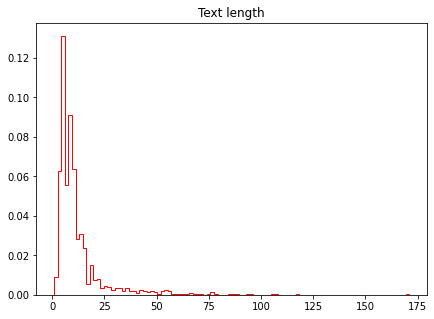

In [5]:
text_df['text'] = text_df['text'].apply(lambda x: pre_processing(x))
length = text_df['text'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(7,5))
plt.hist(length, bins=100,density=1, histtype='step',color="r")
plt.title('Text length')
plt.show()

In [6]:
text_df

,id,text
0,57,everi person right profess practic propag reli...
1,1603,pigment particl mix vehicl way particl distrib...
2,755,prime minist india leader rule parti lok sabha...
3,1636,water drink nowaday safe
4,828,along mother brother sister brought small bamboo
...,...,...
1995,222,agricultur underdevelop product low
1996,926,teacher teacher help student teach good human be
1997,490,take step fulfil demand famili within scarc re...
1998,1293,look care tendon join muscl


In [7]:
!pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.key_to_index.keys():
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text_df["text"])
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=4, n_init=1)

In [ ]:
X

<2000x4939 sparse matrix of type '<class 'numpy.float64'>'
	with 19414 stored elements in Compressed Sparse Row format>

In [ ]:
|text_df["bias"] = model.predict(X)
text_df["bias"]=text_df["bias"].replace({0:0,1:1,2:1,3:1})
text_df = text_df.sort_values(by=["id"]).reset_index().drop("index",axis=1)
pred_bias = []

for i in range(len(df)):
  pred_bias.append((text_df["bias"][df["p1"][i]-1] ^ text_df["bias"][df["p2"][i]-1]))
print(classification_report(df["bias"],pred_bias))
print(confusion_matrix(df["bias"],pred_bias))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59     80400
           1       0.50      0.35      0.41     75551

    accuracy                           0.51    155951
   macro avg       0.51      0.51      0.50    155951
weighted avg       0.51      0.51      0.50    155951

[[53528 26872]
 [48814 26737]]


In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'evaluate_during_training': True,
    'max_seq_length': 512,
    'num_train_epochs': 10,
    'evaluate_during_training_steps': 50,
    'wandb_project': 'sts-b-medium',
    'train_batch_size': 16,
    'regression': True,
}

In [ ]:
from simpletransformers.classification import ClassificationModel
import torch
model = ClassificationModel('roberta', 'roberta-base', num_labels=1, args=train_args,use_cuda=False)

ModuleNotFoundError: ignored

In [ ]:
from scipy.stats import pearsonr, spearmanr

def pearson_corr(preds, labels):
    return pearsonr(preds, labels)[0]

def spearman_corr(preds, labels):
    return spearmanr(preds, labels)[0]

In [ ]:
text_df

In [ ]:
train_df = {'text_a': [], 'text_b': [], 'labels': []}
for i in range(len(df)):
  train_df["text_a"].append(text_df["text"][df["p1"][i]-1])
  train_df["text_b"].append(text_df["text"][df["p2"][i]-1])
  train_df["labels"].append(df["bias"][i])

In [ ]:
train_df = pd.DataFrame(train_df)
eval_df = train_df[15000:155951]
train_df = train_df[:15000]

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
train_encode = tokenizer(list(train_df["text_a"]), list(train_df["text_b"]),padding="max_length")

In [ ]:
test_encode = tokenizer(list(eval_df["text_a"]), list(eval_df["text_b"]),padding="max_length",truncation=True)

In [ ]:
train_seq = torch.tensor(train_encode['input_ids'])
train_mask = torch.tensor(train_encode['attention_mask'])
train_token = torch.tensor(train_encode['token_type_ids'])

In [ ]:
from torch.utils.data import TensorDataset,DataLoader
from transformers import BertForSequenceClassification

train_data = TensorDataset(train_seq, train_mask, train_token, train_df["labels"])
train_dataloader = DataLoader(train_data, batch_size=32,shuffle=True)

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/MyDrive/Acads",num_labels=2)

In [ ]:
train_losses = []
num_mb_train = len(train_dataloader)

import torch.nn as nn
import numpy as np


EPOCHS = 5
criterion = nn.CrossEntropyLoss()


# empty list to save model predictions
total_preds=[]

for epoch in range(EPOCHS):
  train_loss = 0


  
  for step,batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    model.train()

    batch = [r.to(device) for r in batch]
    input_id,attention_mask,token_type_id,y = batch
    

    
    prediction = model(input_id,attention_mask= attention_mask,token_type_ids=token_type_id, labels=y)

    loss = prediction[0]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
        
    train_loss += loss.data / num_mb_train

    print("\nTrain loss after itaration %i: %f" % (epoch+1, train_loss))
    train_losses.append(train_loss.cpu())